# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [36]:

# global
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
from transformers import set_seed
import openai
from datasets import load_dataset
from dotenv import load_dotenv
load_dotenv()

# local 
sys.path.insert(0, '../')
import scripts.image_captioning as ic
from scripts.utils import get_device
# extensions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set seed & device

In [2]:
set_seed(42)    # set seed for reproducibility
# set the device to use
device = get_device()
print(f'Using device: {device}')

Using device: cuda


#### Class instantiation

In [3]:
# instantiate managers
clip_manager = ic.ClipManager(device=device)
image_manager = ic.ImageManager()
vocab_manager = ic.VocabManager()
prompt_generator = ic.LmPromptGenerator()

In [50]:
# setup lm
lm_model = 'gpt' # gpt or huggingface transformer model
# OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5, EleutherAI/gpt-neox-20b
lm_manager = ic.LmManager(version=lm_model, use_api=True, device=device)
openai.api_key = os.getenv('OPENAI_API_KEY')

#### Create image & text embeddings

In [5]:
# compute place & objects features
place_feats = clip_manager.get_text_emb([f'Photo of a {p}.' for p in vocab_manager.place_list])
obj_feats = clip_manager.get_text_emb([f'Photo of a {o}.' for o in vocab_manager.object_list])

## Chain-of-thought reasoning

### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

In [6]:
# load scienceQA dataset
scienceQA_dataset = load_dataset('derek-thomas/ScienceQA', split='validation')
# filter out samples with no image
scienceQA_dataset = [sample for sample in scienceQA_dataset if sample['image'] is not None]

Found cached dataset parquet (/home/neil/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


#### Visualize dataset samples

In [ ]:
# viz samples
# for i, sample in enumerate(scienceQA_dataset[60:70]):
#     print(f'sample {i}:')
#     plt.figure(figsize=(5, 5))
#     plt.imshow(sample['image'])
#     plt.axis('off')
#     plt.show()
#     # sample['image'].show()
#     print('question:', sample['question'])
#     print('choices:', sample['choices'])
#     print('hint:', sample['hint'])
#     # print('lecture:', sample['lecture'])
#     print('answer:', sample['answer'])
#     print('solution:', sample['solution'])
#     print('-'*50)

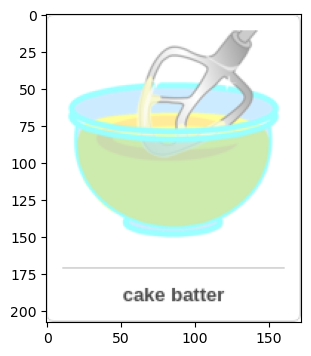

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.


In [51]:
# select & viz sample
sample_idx = 122
sample = scienceQA_dataset[sample_idx]
plt.figure(figsize=(4, 4))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

In [71]:
# compose prompt
prompt = prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a kitchen. It contains a clabber, eggbeater, blender, whipping cream, batter, fondant, contrivance, gismo, widget, sifter.
Question: Which property matches this object?
Choices: ['sweet', 'bouncy']
Hint: Select the better answer.
Answer: Let's think step by step...



In [82]:
# generate output
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 0.7, 'n': 1}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 50, 'temperature': 1., 'do_sample': True, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)

print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

output: Clabber - not sweet or bouncy
Eggbeater - not sweet or bouncy
Blender - not sweet or bouncy
Whipping cream - sweet, but not bouncy
Batter - not sweet or bouncy
Fondant - sweet, but not bouncy
Contrivance - not a property
Gismo - not a property
Widget - not a property
Sifter - not sweet or bouncy

Therefore, the answer is sweet.
gt solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
gt answer: 0


### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

example sample:


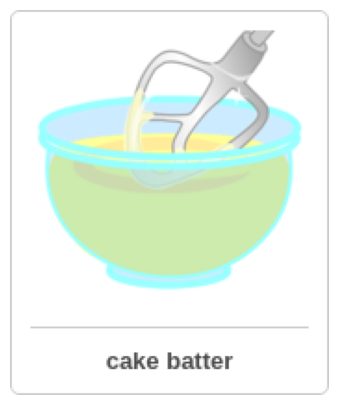

question: Which property matches this object?
choices: ['sweet', 'bouncy']
answer: 0
solution: Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.
target sample:


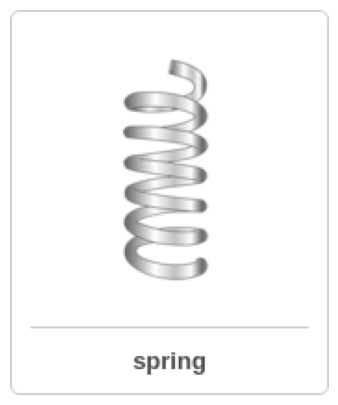

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [29]:
# select & viz example & target samples
# candidate pairs: single-prop: 122, 142 | multi-prop: 340, 142, 
# sample example
eg_sample_idx, target_sample_idx = 122, 142
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(5, 5))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(4, 4))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [38]:
# generate prompt
prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a kitchen. It contains a clabber, eggbeater, blender, whipping cream, batter, fondant, contrivance, gismo, widget, sifter.
Question: Which property matches this object?
Choices: ['sweet', 'bouncy']
Answer: Let's think step by step...Look at the object.
Think about each property.
Sugar has a sweet taste. The cake batter is sweet.
A bouncy object will bounce back from the floor if you drop it. The cake batter is not bouncy.. So the answer is sweet
This image was taken in a drugstore. It contains a spring, spring scale, coil, volute, sprig, set gun, whipping cream, elastic, spar, whisk.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Answer: Let's think step by step...



In [ ]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_new_tokens': 100, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 100, 'temperature': 1., 'do_sample': False, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {target_sample["answer"]}')

### Zero-shot VQA
Zero-shot visual question-answering using VLM (CLIP + LM)

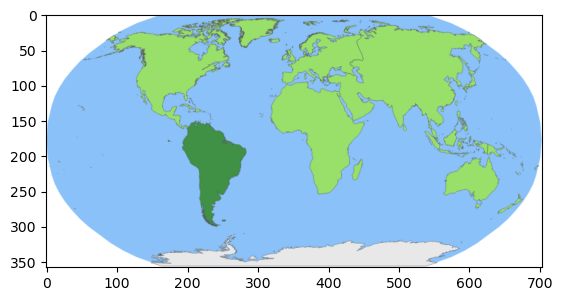

question: Which continent is highlighted?
choices: ['South America', 'Antarctica', 'North America']
answer: 0
solution: This continent is South America.


In [34]:
# get sample
sample_idx = 134
sample = scienceQA_dataset[sample_idx]
# show sample
plt.figure(figsize=(4, 4))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [35]:
# compose prompt
prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_new_tokens': 20, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 20, 'temperature': 1., 'do_sample': False} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt answer: {sample["answer"]}')

prompt: This image was taken in a rainforest. It contains a Latin American, part, tennis ball, unit, geographical point, caranday, caranda palm, Copernicia australis, asclepiad, horseshoe. Using this information, answer the following question: Which continent is highlighted?
        Choices: ['South America', 'Antarctica', 'North America']
        Answer: 

output: South America

gt answer: 0
